In [1]:
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


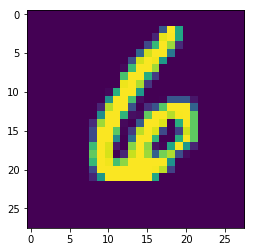

In [2]:
plt.imshow(mnist.load_data()[0][0][155])

In [3]:
# standard model
from keras.layers import Conv2D, Dense, Flatten, Dropout, Lambda

model = keras.models.Sequential()
model.add(Lambda(lambda x: x/256, input_shape=(28,28,1)))
model.add(Conv2D(32, 3, strides=2))
# model.add(Dropout(0.5))
model.add(Conv2D(32, 5, strides=2))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(80, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile('adam', 'categorical_crossentropy', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 32)          25632     
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                64080     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                810       
Total params: 90,842
Trainable params: 90,842
Non-trainable params: 0
_________________________________________________________________


In [4]:
train, test = mnist.load_data()
model.fit(train[0].reshape(-1, 28, 28, 1), keras.utils.to_categorical(train[1]), epochs=5)

Epoch 1/5
60000/60000 [==============================] - 9s 151us/step - loss: 0.2159 - acc: 0.9357
Epoch 2/5
60000/60000 [==============================] - 10s 172us/step - loss: 0.1066 - acc: 0.9672
Epoch 3/5
60000/60000 [==============================] - 12s 199us/step - loss: 0.0826 - acc: 0.9744
Epoch 4/5
60000/60000 [==============================] - 11s 187us/step - loss: 0.0709 - acc: 0.9778
Epoch 5/5
60000/60000 [==============================] - 11s 190us/step - loss: 0.0610 - acc: 0.9814


In [5]:
model.evaluate(test[0].reshape(-1, 28, 28, 1), keras.utils.to_categorical(test[1]))

10000/10000 [==============================] - 1s 67us/step


[0.08351908588460646, 0.9751]

In [6]:
# Now given this model, calculate information gains after the first layer

w = model.layers[1].get_weights()
small = keras.models.Sequential()
small.add(Lambda(lambda x: x/256, input_shape=(28,28,1)))
small.add(Conv2D(32, 3, strides=2))
small.layers[1].set_weights(w)
preds = small.predict(test[0].reshape(-1, 28, 28, 1))

In [7]:
means = preds.mean((0,1,2))
classifications = preds > means

In [8]:
import numpy as np

for ax in range(32):
    first = classifications[:, :, :, ax].ravel()
    predictions = []
    for other in set(range(32)) - {ax}:
        second = classifications[:, :, :, other].ravel()
        predictions.append((first == second).mean())
    mean = np.array(predictions).max()
    print("Filter {} has maximum alignment of {}".format(ax, mean))
    

Filter 0 has maximum alignment of 0.9512254437869823
Filter 1 has maximum alignment of 0.9618337278106509
Filter 2 has maximum alignment of 0.9435449704142012
Filter 3 has maximum alignment of 0.9218810650887574
Filter 4 has maximum alignment of 0.9159443786982249
Filter 5 has maximum alignment of 0.9535520710059172
Filter 6 has maximum alignment of 0.9621656804733728
Filter 7 has maximum alignment of 0.9588082840236687
Filter 8 has maximum alignment of 0.9050426035502959
Filter 9 has maximum alignment of 0.9159443786982249
Filter 10 has maximum alignment of 0.957198224852071
Filter 11 has maximum alignment of 0.8701236686390532
Filter 12 has maximum alignment of 0.9074195266272189
Filter 13 has maximum alignment of 0.9346579881656805
Filter 14 has maximum alignment of 0.9435449704142012
Filter 15 has maximum alignment of 0.9543289940828402
Filter 16 has maximum alignment of 0.9621656804733728
Filter 17 has maximum alignment of 0.8997934911242603
Filter 18 has maximum alignment of 0.91

In [9]:
# Therefore removing filter 11 should harm the network the most...

train, test = mnist.load_data()
losses = []

for ix in range(32):
    w = model.layers[1].get_weights()
    w[0] = w[0].copy()
    w[1] = w[1].copy()
    w[0][:, :, :, ix] = 0
    w[1][ix] = 0
    m = keras.models.Sequential()
    m.add(Lambda(lambda x: x/256, input_shape=(28,28,1)))
    m.add(Conv2D(32, 3, strides=2))
    m.layers[1].set_weights(w)
    m.layers[1].trainable = False
    m.add(Conv2D(32, 5, strides=2))
    m.add(Flatten())
    m.add(Dense(80, activation='relu'))
    m.add(Dense(10, activation='softmax'))
    m.summary()
    m.compile('adam', 'categorical_crossentropy', metrics=['acc'])
    m.fit(train[0].reshape(-1, 28, 28, 1), keras.utils.to_categorical(train[1]), epochs=5, verbose=0)
    losses.append(m.evaluate(test[0].reshape(-1, 28, 28, 1), keras.utils.to_categorical(test[1])))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 32)          25632     
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                64080     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                810       
Total params: 90,842
Trainable params: 90,522
Non-trainable params: 320
_________________________________________________________________
1000

10000/10000 [==============================] - 1s 66us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 5, 5, 32)          25632     
_________________________________________________________________
flatten_9 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 80)                64080     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                810       
Total params: 90,842
Trainable params: 90,522
Non-trainable params: 320
__________

10000/10000 [==============================] - 1s 103us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_17 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 5, 5, 32)          25632     
_________________________________________________________________
flatten_16 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 80)                64080     
_________________________________________________________________
dense_32 (Dense)             (None, 10)                810       
Total params: 90,842
Trainable params: 90,522
Non-trainable params: 320
_________

10000/10000 [==============================] - 2s 155us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_24 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 5, 5, 32)          25632     
_________________________________________________________________
flatten_23 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 80)                64080     
_________________________________________________________________
dense_46 (Dense)             (None, 10)                810       
Total params: 90,842
Trainable params: 90,522
Non-trainable params: 320
_________

10000/10000 [==============================] - 2s 155us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_31 (Lambda)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 5, 5, 32)          25632     
_________________________________________________________________
flatten_30 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 80)                64080     
_________________________________________________________________
dense_60 (Dense)             (None, 10)                810       
Total params: 90,842
Trainable params: 90,522
Non-trainable params: 320
_________

In [10]:
losses

[[0.09220675411213888, 0.9738],
 [0.08119918570137816, 0.9761],
 [0.1012763194594183, 0.9697],
 [0.09967396029215306, 0.9728],
 [0.08642025889768265, 0.9759],
 [0.08637530559895094, 0.9748],
 [0.08791261193405371, 0.9739],
 [0.0886623264702037, 0.9754],
 [0.07995075087632285, 0.9757],
 [0.09106968169831671, 0.9742],
 [0.10717277544690296, 0.9696],
 [0.08601696288941894, 0.9748],
 [0.10641980986215349, 0.9715],
 [0.0811992616501404, 0.9764],
 [0.09050734994594241, 0.9759],
 [0.08532155935182237, 0.9756],
 [0.09655246881004423, 0.9727],
 [0.09176438778855373, 0.9744],
 [0.08253133787943516, 0.9763],
 [0.10171432432390284, 0.9712],
 [0.0892571656991262, 0.9757],
 [0.08507448551647831, 0.9747],
 [0.08765585997691377, 0.9747],
 [0.10219235071048606, 0.9703],
 [0.09430274787915405, 0.9736],
 [0.09727025765986182, 0.9731],
 [0.0796539090998238, 0.9766],
 [0.0888964265217015, 0.974],
 [0.08687666245914297, 0.9753],
 [0.09854314623294631, 0.9737],
 [0.0961814725116361, 0.9739],
 [0.090300761066

In [11]:
np.array([x[0] for x in losses]).argmax()

10

In [13]:
np.array([x[1] for x in losses]).argmin()

10

In [14]:
# Therefore it does not work like that, there must be other method of telling whether feature is good or not